In [12]:
! pip install emoji

In [13]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import emoji
import nltk
import string

nltk.download('popular')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [14]:
df = pd.read_csv("/content/drive/MyDrive/MY ML PROJECTS/FlipKart Sentiment Analysis/Flipkart Review Clean.csv")
df.head()

,final_text,sentiment
0,not good broken middleread,1
1,wastage moneyread,1
2,local productsread,1
3,best headphone life good sound quality good ba...,0
4,use month no problem sound body excellent,0


In [15]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df["final_text"],
                                                      df["sentiment"]  ,
                                                      test_size=0.25,
                                                      random_state=42,stratify=df["sentiment"])
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((3236,), (1079,), (3236,), (1079,))

In [16]:
#Numbers of unique Words in X_train
unique_words = []
for x in X_train:
  unique_words.extend(x.split())
len(set(unique_words))



4220

In [17]:
# Find average number of tokens (words) in training
sum([len(review.split()) for review in X_train])/len(X_train)


11.376081582200246

In [18]:
lenth = []
for x in X_train:
  lenth.append(len(x.split()))

In [19]:
data = pd.Series(lenth)

In [20]:
data.describe()

count    3236.000000
mean       11.376082
std        10.698038
min         1.000000
25%         4.000000
50%         8.000000
75%        15.000000
max        55.000000
dtype: float64

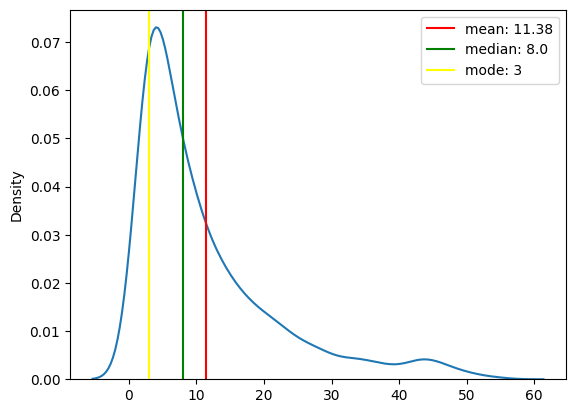

In [22]:
import matplotlib.pyplot as plt

sns.kdeplot(data)
plt.axvline(data.mean(),color = "red",
            label = f"mean: {round(data.mean(),2)}")
plt.axvline(data.median(),color = "green",
            label = f"median: {round(data.median(),2)}")
plt.axvline(data.mode()[0],color = "yellow",
            label = f"mode: {round(data.mode()[0],2)}")
plt.legend()
plt.show()

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=17) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None
text_vectorizer.adapt(X_train)

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 4222
Top 5 most common words: ['', '[UNK]', 'good', 'sound', 'product']
Bottom 5 least common words: ['abov', 'abd', 'aata', 'aakash', 'aacha']


## using Tensorflow Embadding layer

In [25]:
from tensorflow.keras.layers import Embedding
ebd_layer = Embedding(
    input_dim = len(text_vectorizer.get_vocabulary()),
    output_dim = 128,
    input_length = 12
)

In [26]:
input = tf.keras.layers.Input(shape = (1,), dtype= "string")
tv = text_vectorizer(input)
ebd = ebd_layer(tv)
ga = tf.keras.layers.GlobalAveragePooling1D()(ebd)
d1 = tf.keras.layers.Dense(16, activation = "relu")(ga)
output = tf.keras.layers.Dense(1, activation = "sigmoid")(d1)

model_ebd = tf.keras.Model(inputs = input, outputs = output)
model_ebd.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 17)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 17, 128)           540416    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17    

In [27]:
tf.random.set_seed(42)

model_ebd.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

# train_sentences, val_sentences, train_labels, val_labels

result_ebd = model_ebd.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))

Epoch 1/10
102/102 [==============================] - 3s 14ms/step - loss: 0.6352 - accuracy: 0.6360 - val_loss: 0.5781 - val_accuracy: 0.6756
Epoch 2/10
102/102 [==============================] - 1s 9ms/step - loss: 0.4680 - accuracy: 0.7896 - val_loss: 0.4260 - val_accuracy: 0.8267
Epoch 3/10
102/102 [==============================] - 1s 9ms/step - loss: 0.3252 - accuracy: 0.8773 - val_loss: 0.3999 - val_accuracy: 0.8323
Epoch 4/10
102/102 [==============================] - 1s 9ms/step - loss: 0.2622 - accuracy: 0.9104 - val_loss: 0.4000 - val_accuracy: 0.8434
Epoch 5/10
102/102 [==============================] - 1s 11ms/step - loss: 0.2222 - accuracy: 0.9286 - val_loss: 0.4138 - val_accuracy: 0.8276
Epoch 6/10
102/102 [==============================] - 1s 9ms/step - loss: 0.1890 - accuracy: 0.9385 - val_loss: 0.4253 - val_accuracy: 0.8323
Epoch 7/10
102/102 [==============================] - 1s 9ms/step - loss: 0.1626 - accuracy: 0.9475 - val_loss: 0.4574 - val_accuracy: 0.8165
Epoc

In [28]:
y_pred_ebd = model_ebd.predict(X_valid)
y_pred_ebd[:5]

34/34 [==============================] - 0s 2ms/step


array([[0.7916919 ],
       [0.00186867],
       [0.7338486 ],
       [0.00315256],
       [0.00371827]], dtype=float32)

In [29]:
np.where(y_pred_ebd>=0.5, 1,0)

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [30]:
y_pred_ebd_flat = np.round(y_pred_ebd).flatten()
y_pred_ebd_flat[:5]

array([1., 0., 1., 0., 0.], dtype=float32)

In [31]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_valid, y_pred_ebd_flat))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       685
           1       0.76      0.75      0.75       394

    accuracy                           0.82      1079
   macro avg       0.81      0.81      0.81      1079
weighted avg       0.82      0.82      0.82      1079



In [32]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score for class 1
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred)
  model_results = {"Accuracy": [np.round(model_accuracy,2)],
                  "Precision": [np.round(model_precision[1]* 100,2)],
                  "Recall": [np.round(model_recall[1]* 100,2)],
                  "F1_score": [np.round(model_f1[1]* 100,2)]}
  return model_results

In [33]:
# Get baseline results
model_results = calculate_results(y_true=y_valid,
                                     y_pred=tf.round(y_pred_ebd))
model_results

{'Accuracy': [82.02],
 'Precision': [75.51],
 'Recall': [75.13],
 'F1_score': [75.32]}

In [34]:
result_df = pd.DataFrame({
        "Description": [],
        "Precision": [],
        "Recall": [],
        "F1_score":[],
        "Accuracy":[],
        "Pred_time_in_seconds" : []
    })

In [35]:
import time
def result_log(model,text,X_test, y_true,result_df):
  start_time = time.time()
  y_pred = model.predict(X_test)
  end_time = time.time()
  pred_time = end_time - start_time
  result_dict = calculate_results(y_true=y_valid,y_pred=tf.round(y_pred))
  result_dict["Description"] = text
  result_dict["Pred_time_in_seconds"] = [pred_time]
  temp_df = pd.DataFrame(data = result_dict)
  result_df = pd.concat([result_df, temp_df]).reset_index(drop = True)

  return result_df

In [36]:
import joblib
model_nb = joblib.load("/content/drive/MyDrive/MY ML PROJECTS/FlipKart Sentiment Analysis/Model/flipkart_review,joblib")
model_nb

Pipeline(steps=[('bow', CountVectorizer()), ('nb', MultinomialNB())])

In [37]:
result_df = result_log(model_nb,"naive bayes",X_valid, y_valid, result_df)
result_df

,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,85.16,78.68,81.79,87.21,0.035724


In [38]:
result_df = result_log(model_ebd,"Embedding model",X_valid, y_valid, result_df)
result_df

34/34 [==============================] - 0s 3ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,85.16,78.68,81.79,87.21,0.035724
1,Embedding model,75.51,75.13,75.32,82.02,0.233633


In [39]:
from tensorflow.keras import layers
max_vocab_length = len(text_vectorizer.get_vocabulary())
max_length = 12
embedding = layers.Embedding(input_dim= max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize uniform
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [40]:
from tensorflow.keras import layers

input = layers.Input(shape = (1,), dtype = "string")
tv = text_vectorizer(input)
ebd = embedding(tv)
ga = layers.GlobalAveragePooling1D()(ebd)
# d1 = layers.Dense(64, activation = "relu")(ga)
output = layers.Dense(1, activation = "sigmoid")(ga)

In [41]:
model = tf.keras.Model(inputs = input, outputs = output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 17)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 17, 128)           540416    
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 540545 (2.06 MB)
Trainable params: 540545 (2.

In [42]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

# train_sentences, val_sentences, train_labels, val_labels

model.fit(X_train, y_train, epochs = 5, validation_data = (X_valid, y_valid))

Epoch 1/5
102/102 [==============================] - 3s 14ms/step - loss: 0.6367 - accuracy: 0.6493 - val_loss: 0.5947 - val_accuracy: 0.6691
Epoch 2/5
102/102 [==============================] - 1s 8ms/step - loss: 0.5356 - accuracy: 0.7253 - val_loss: 0.5076 - val_accuracy: 0.7572
Epoch 3/5
102/102 [==============================] - 1s 8ms/step - loss: 0.4359 - accuracy: 0.8195 - val_loss: 0.4492 - val_accuracy: 0.7924
Epoch 4/5
102/102 [==============================] - 1s 9ms/step - loss: 0.3701 - accuracy: 0.8569 - val_loss: 0.4237 - val_accuracy: 0.8054
Epoch 5/5
102/102 [==============================] - 1s 9ms/step - loss: 0.3269 - accuracy: 0.8820 - val_loss: 0.4122 - val_accuracy: 0.8332


In [43]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(4222, 128) dtype=float32, numpy=
 array([[-0.00161137,  0.01132152, -0.03497309, ...,  0.00505062,
          0.05256931,  0.03006224],
        [-0.02051891,  0.00637603, -0.03371644, ..., -0.04906217,
          0.04026146,  0.04686834],
        [ 0.11473492,  0.18812549, -0.10024253, ..., -0.14497666,
          0.16844174,  0.13683417],
        ...,
        [-0.08246853, -0.06019575,  0.03904735, ...,  0.08876427,
         -0.09024806, -0.05164006],
        [ 0.02862946,  0.05395107, -0.05635308, ..., -0.06218388,
         -0.01212883, -0.00409022],
        [ 0.02459957,  0.02733385, -0.07453871, ..., -0.00885684,
          0.0685403 ,  0.08173042]], dtype=float32)>]

In [44]:
model.get_layer("embedding_1").get_weights()


[array([[-0.00161137,  0.01132152, -0.03497309, ...,  0.00505062,
          0.05256931,  0.03006224],
        [-0.02051891,  0.00637603, -0.03371644, ..., -0.04906217,
          0.04026146,  0.04686834],
        [ 0.11473492,  0.18812549, -0.10024253, ..., -0.14497666,
          0.16844174,  0.13683417],
        ...,
        [-0.08246853, -0.06019575,  0.03904735, ...,  0.08876427,
         -0.09024806, -0.05164006],
        [ 0.02862946,  0.05395107, -0.05635308, ..., -0.06218388,
         -0.01212883, -0.00409022],
        [ 0.02459957,  0.02733385, -0.07453871, ..., -0.00885684,
          0.0685403 ,  0.08173042]], dtype=float32)]

In [45]:
embed_weights = model.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(4222, 128)


In [46]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## RNN Model

In [47]:
tf.random.set_seed(42)
from tensorflow.keras import layers
max_vocab_length = len(text_vectorizer.get_vocabulary())
max_length = 12

model_1_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create rnn model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_1_embedding(x)
# print(x.shape)
x = layers.Dropout(0.2)(x)
x = layers.SimpleRNN(4, return_sequences=True, dropout = 0.2, kernel_regularizer='l1')(x) # return vector for whole sequence
# x = layers.SimpleRNN(8, return_sequences=True, dropout = 0.4, kernel_regularizer='l1')(x)
x = layers.SimpleRNN(4, dropout = 0.2, kernel_regularizer='l1')(x)
# print(x.shape)
x = layers.Dropout(0.2)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_RNN")
model_1.summary()

Model: "model_1_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 17)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 17, 128)           540416    
                                                                 
 dropout (Dropout)           (None, 17, 128)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 17, 4)             532       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 36        
                                                       

In [48]:
tf.random.set_seed(42)
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
                metrics=["accuracy"])

# Fit model
model_1_history = model_1.fit(X_train,
                              y_train,
                              epochs=6,
                              validation_data=(X_valid, y_valid)
                              )

Epoch 1/6
102/102 [==============================] - 5s 22ms/step - loss: 1.2009 - accuracy: 0.6316 - val_loss: 1.0607 - val_accuracy: 0.7915
Epoch 2/6
102/102 [==============================] - 3s 28ms/step - loss: 0.9649 - accuracy: 0.7960 - val_loss: 0.8873 - val_accuracy: 0.8109
Epoch 3/6
102/102 [==============================] - 2s 22ms/step - loss: 0.7877 - accuracy: 0.8634 - val_loss: 0.7556 - val_accuracy: 0.8248
Epoch 4/6
102/102 [==============================] - 2s 17ms/step - loss: 0.6421 - accuracy: 0.8918 - val_loss: 0.6849 - val_accuracy: 0.8156
Epoch 5/6
102/102 [==============================] - 2s 18ms/step - loss: 0.5578 - accuracy: 0.9070 - val_loss: 0.6285 - val_accuracy: 0.8258
Epoch 6/6
102/102 [==============================] - 2s 18ms/step - loss: 0.4978 - accuracy: 0.9181 - val_loss: 0.6103 - val_accuracy: 0.8221


In [49]:
result_df = result_log(model_1,"rnn model",X_valid, y_valid, result_df)
result_df

34/34 [==============================] - 0s 3ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,85.16,78.68,81.79,87.21,0.035724
1,Embedding model,75.51,75.13,75.32,82.02,0.233633
2,rnn model,73.71,79.70,76.59,82.21,0.450632


In [50]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(8, return_sequences=True, dropout = 0.4, kernel_regularizer='l1')(x) # return vector for whole sequence
x = layers.LSTM(8)(x)
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")
model_2.summary()

(None, 17, 128)
(None, 8)
Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 17)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 17, 128)           540416    
                                                                 
 lstm (LSTM)                 (None, 17, 8)             4384      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                            

In [51]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=2,
                              validation_data=(X_valid, y_valid)
                              )

Epoch 1/2
102/102 [==============================] - 8s 34ms/step - loss: 2.8944 - accuracy: 0.6452 - val_loss: 1.4384 - val_accuracy: 0.7683
Epoch 2/2
102/102 [==============================] - 2s 21ms/step - loss: 0.7563 - accuracy: 0.8415 - val_loss: 0.4816 - val_accuracy: 0.8285


In [52]:
result_df = result_log(model_2,"model_2_LSTM",X_valid, y_valid, result_df)
result_df

34/34 [==============================] - 1s 4ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,85.16,78.68,81.79,87.21,0.035724
1,Embedding model,75.51,75.13,75.32,82.02,0.233633
2,rnn model,73.71,79.70,76.59,82.21,0.450632
3,model_2_LSTM,74.47,80.71,77.47,82.85,1.042563


## Transfer learning universal sentence encoder

In [53]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2") # load Universal Sentence Encoder
embed_samples = embed(["When you call the universal sentence encoder on a sentence" ,"it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[ 0.06244392 -0.05404239 -0.01550858  0.01542972  0.01788068 -0.03036544
 -0.0538453   0.04314862  0.05359636  0.0120719  -0.01811362 -0.01782004
  0.05830162  0.06650332  0.05286517 -0.10197278  0.00336003 -0.04389289
  0.00443687  0.04345386  0.04878574  0.01747908  0.03758943  0.04342709
 -0.07960427  0.08850855 -0.04610324 -0.01990385  0.00587059  0.01095503
  0.06020493  0.0401582  -0.02054349 -0.02344939 -0.09796889 -0.01216926
  0.07869855  0.05636844 -0.03875325 -0.0128826  -0.00144699 -0.00484139
  0.06665631 -0.01310721 -0.03005807  0.00293552 -0.01266199 -0.05068604
 -0.03806402 -0.00441731], shape=(50,), dtype=float32)


In [54]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
import tensorflow_hub as hub
from tensorflow.keras import layers
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [55]:
# Create model using the Sequential API
import tensorflow as tf
model_3 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_3_USE")

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0008),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [56]:
# Train a classifier on top of pretrained embeddings

model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=4,
                              validation_data=(X_valid, y_valid)
                              )

Epoch 1/4
102/102 [==============================] - 4s 17ms/step - loss: 0.5285 - accuracy: 0.7651 - val_loss: 0.4320 - val_accuracy: 0.8137
Epoch 2/4
102/102 [==============================] - 1s 12ms/step - loss: 0.3900 - accuracy: 0.8418 - val_loss: 0.3975 - val_accuracy: 0.8221
Epoch 3/4
102/102 [==============================] - 1s 12ms/step - loss: 0.3671 - accuracy: 0.8511 - val_loss: 0.3921 - val_accuracy: 0.8239
Epoch 4/4
102/102 [==============================] - 1s 12ms/step - loss: 0.3554 - accuracy: 0.8563 - val_loss: 0.3889 - val_accuracy: 0.8230


In [57]:
result_df = result_log(model_3,"model_3_USE",X_valid, y_valid, result_df)
result_df

34/34 [==============================] - 1s 8ms/step


,Description,Precision,Recall,F1_score,Accuracy,Pred_time_in_seconds
0,naive bayes,85.16,78.68,81.79,87.21,0.035724
1,Embedding model,75.51,75.13,75.32,82.02,0.233633
2,rnn model,73.71,79.70,76.59,82.21,0.450632
3,model_2_LSTM,74.47,80.71,77.47,82.85,1.042563
4,model_3_USE,79.25,69.80,74.22,82.30,0.749553


## Save USE Model

In [64]:
tf.saved_model.save(model_3, "Flipkart_review_use_model")

In [ ]:
with open("/content/drive/MyDrive/MY ML PROJECTS/FlipKart Sentiment Analysis/sw_new.txt","r") as f:
  sw_new = f.read()
sw_new = sw_new.split("\n")
sw_new


In [60]:
def text_cleaner(text, sw = sw_new):
  import re
  import emoji
  import string
  from nltk.stem import PorterStemmer,WordNetLemmatizer

  # mobile_regex = "(\+*)((0[ -]*)*|((91 )*))((\d{12})+|(\d{10})+)|\d{5}([- ]*)\d{6}"
  url_regex = "((http|https|www)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
  space_regex = "\s\s+"
  # remove url
  text = re.sub(url_regex, "", text)
  # remove mobile
  # text = re.sub(mobile_regex, "", text)
  # lower casing
  text = text.lower()
  # remove emoji & punctuation and Numbers
  text = "".join([i for i in text if (ord(i) in range(97,123)) | (i == " ")])
  # remove multiple spaces
  text = re.sub(space_regex, " ", text)
  # stopword removal
  text = [i for i in text.split() if i not in sw]
  # lemmatizing
  lemma = WordNetLemmatizer()
  text = " ".join([lemma.lemmatize(i) for i in text])



  return text

In [61]:
def prediction(text):
  text = text_cleaner(text)
  y_pred = model_nb.predict([text])
  print(("Negative Review" if y_pred[0] == 1 else "Positive Review"))

In [62]:
text = '''
Dont buy this phone, battery drain in 3 to 4 hr after regular use
'''

In [63]:
prediction(text)

Positive Review


In [65]:
! zip -r use.zip /content/Flipkart_review_use_model

  adding: content/Flipkart_review_use_model/ (stored 0%)
  adding: content/Flipkart_review_use_model/assets/ (stored 0%)
  adding: content/Flipkart_review_use_model/fingerprint.pb (stored 0%)
  adding: content/Flipkart_review_use_model/saved_model.pb (deflated 67%)
  adding: content/Flipkart_review_use_model/variables/ (stored 0%)
  adding: content/Flipkart_review_use_model/variables/variables.index (deflated 78%)
  adding: content/Flipkart_review_use_model/variables/variables.data-00000-of-00001 (deflated 7%)
